In [1]:
!python -m pip install cma
!python -m pip install gymnasium

In [30]:
import numpy as np
import functools
from random import Random
from cma import CMAEvolutionStrategy as cmaes
import gymnasium as gym
import torch
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm

Utility wrapper for the CMAES optimizer

In [31]:

def generator(random, args):
    return np.asarray([random.uniform(args["pop_init_range"][0],
                                      args["pop_init_range"][1])
                       for _ in range(args["num_vars"])])


def generator_wrapper(func):
    @functools.wraps(func)
    def _generator(random, args):
        return np.asarray(func(random, args))

    return _generator


class Optimizer():

    def __init__(self, num_vars, seed=0, pop_init_range=[-1,1], lmbda=20, mu=10, sigma=1.):
        args = {
            "num_vars": num_vars,
            "pop_init_range": pop_init_range,
        }
        self.cmaes = cmaes(generator(Random(seed), args),
                           sigma,
                           {'popsize': lmbda,
                            'seed': seed,
                            'CMA_mu': mu})
        self.pop = []
        self.best = None

    def tell(self, fitness):
        self.cmaes.tell(self.pop, fitness)
        self.best = self.cmaes.best

    def ask(self):
        self.pop = self.cmaes.ask()
        return self.pop[:]



Evaluation function

In [33]:
def eval(params):
    cumulative_rewards = []
    task = gym.make("CartPole-v1")
    # the Agent is a NCHL network with 4 inputs, one hidden layer with 10 nodes and 2 outputs
    nodes = [4, 10, 2]
    agent = NCHL(nodes)
    # We set the hebbian rules of the model
    agent.set_params(params)
    obs, info = task.reset()
    rews = []
    done = False
    truncated =False
    for i in range(1):
        rews.append(0)
        while not (done or truncated):
            input = torch.tensor(obs)
            # we obtain the output of the network with the forward method
            output = agent.forward(input)
            # We update the weights with the following method
            agent.update_weights()

            obs, rew, done, truncated,  info = task.step(np.argmax(output.tolist()))
            rews[-1] += rew
    return -np.mean(rews)



The follwing cell will use CMAES to optimize the Hebbian rules of a NCHL model to solve the cartpole task.

In [16]:

class NN(nn.Module):
    def __init__(self, nodes: list, grad=False, init=None, device="cpu"):
        super(NN, self).__init__()
        self.device = torch.device(device)
        self.nodes = torch.tensor(nodes).to(self.device)
        self.nweights = sum([self.nodes[i] * self.nodes[i + 1] for i in
                             range(len(self.nodes) - 1)])  # nodes[0]*nodes[1]+nodes[1]*nodes[2]+nodes[2]*nodes[3]

        self.networks = []
        self.activations = []
        self.grad = grad
        for i in range(len(nodes) - 1):
            self.networks.append(nn.Linear(nodes[i], nodes[i + 1], bias=False))
        if init is None:
            self.set_weights([0. for _ in range(self.nweights)])
        else:
            for l in self.networks:
                if init == 'xa_uni':
                    torch.nn.init.xavier_uniform(l.weight.data, 0.3)
                elif init == 'sparse':
                    torch.nn.init.sparse_(l.weight.data, 0.8)
                elif init == 'uni':
                    torch.nn.init.uniform_(l.weight.data, -0.1, 0.1)
                elif init == 'normal':
                    torch.nn.init.normal_(l.weight.data, 0, 0.024)
                elif init == 'ka_uni':
                    torch.nn.init.kaiming_uniform_(l.weight.data, 3)
                elif init == 'uni_big':
                    torch.nn.init.uniform_(l.weight.data, -1, 1)
                elif init == 'xa_uni_big':
                    torch.nn.init.xavier_uniform(l.weight.data)
        self.double()

    def forward(self, inputs):
        with torch.no_grad():
            self.activations = []
            x = inputs.to(self.device)
            self.activations.append(torch.clone(x).to(self.device))
            # print(x)
            c = 0
            for l in self.networks:
                x = l(x)
                # print(x, l.weight.data)
                x = torch.tanh(x)

                c += 1
                self.activations.append(torch.clone(x))

            return x

    def get_weights(self):
        tmp = []
        for l in self.networks:
            tmp.append(l.weight.data)
        return tmp

    def set_weights(self, weights):
        if type(weights) == list and type(weights[0]) == torch.Tensor:
            for i in range(len(self.networks)):
                self.networks[i].weight = nn.Parameter(weights[i], requires_grad=self.grad)
        elif len(weights) == self.nweights:
            tmp = self.get_weights()
            start = 0
            i = 0
            for l in tmp:
                size = l.size()[0] * l.size()[1] + start
                params = torch.tensor(weights[start:size])
                start = size
                self.networks[i].weight = nn.Parameter(
                    torch.reshape(params, (l.size()[0], l.size()[1])).to(self.device))
                i += 1


class NCHL(NN):
    def __init__(self, nodes: list, params=None, grad=False, device="cpu", init=None):
        super(NCHL, self).__init__(nodes, grad=grad, device=device, init=init)

        self.hrules = []
        self.nparams = sum(self.nodes) * 5 - self.nodes[0] - self.nodes[-1]
        self.eta = []

        self.eta = None
        if params is not None:
            self.set_params(params)

    def set_params(self, params: list):
        etas = params[:sum(self.nodes)]
        hrules = params[sum(self.nodes):]

        self.set_hrules(hrules)
        self.set_eta(etas)

    def set_hrules(self, hrules: list):

        assert len(hrules) == sum(self.nodes) * 4 - self.nodes[0] - self.nodes[-1], "needed " + str(
            sum(self.nodes) * 4 - self.nodes[0] - self.nodes[-1]) + " received " + str(len(hrules))
        start = 0
        size = self.nodes[0] * 3 + start
        tmp = np.reshape(hrules[start:size], (self.nodes[0], 3))
        tmp1 = np.zeros((self.nodes[0], 4))
        for i in range(self.nodes[0]):
            tmp1[i] = np.insert(tmp[i], 1, 0.)

        params = torch.tensor(tmp1)
        self.hrules.append(params)

        for l in self.nodes[1:-1]:
            size = l * 4 + start
            params = torch.tensor(hrules[start:size])
            self.hrules.append(torch.reshape(params, (l, 4)))

            start = size

        size = self.nodes[-1] * 3 + start
        params = torch.tensor(hrules[start:size])
        tmp = torch.reshape(params, (self.nodes[-1], 3))
        tmp1 = torch.tensor([[0.] for i in range(self.nodes[-1])])
        self.hrules.append(torch.hstack((tmp1, tmp)).to(self.device))

    def set_eta(self, etas: list):
        assert len(etas) == sum(self.nodes), "needed " + str(
            sum(self.nodes)) + " received " + str(len(etas))
        self.eta = []
        start = 0
        for l in self.nodes:
            self.eta.append(torch.tensor(etas[start:start + l]).to(self.device))
            start += l

    def update_weights(self):
        weights = self.get_weights()
        num_layers = len(weights)
        t = time.time()
        dws = []
        for i in range(num_layers):
            l = weights[i]

            l_size = l.shape
            activations_i = self.activations[i].to(self.device)
            activations_i1 = self.activations[i + 1].to(self.device)
            hrule_i = self.hrules[i].to(self.device)
            hrule_i1 = self.hrules[i + 1].to(self.device)

            # Use broadcasting to perform element-wise operations without loops

            pre_i = torch.reshape(hrule_i[:, 0] * activations_i, (1, activations_i.size()[0]))
            pre_i = pre_i.repeat((activations_i1.size()[0], 1))
            post_j = torch.reshape(hrule_i1[:, 1] * activations_i1, (activations_i1.size()[0], 1))
            post_j = post_j.repeat((1, activations_i.size()[0]))

            c_i = torch.reshape(torch.where(hrule_i[:, 2] == 1., 1., hrule_i[:, 2] * activations_i),
                                (1, activations_i.size()[0]))
            c_j = torch.reshape(torch.where(hrule_i1[:, 2] == 1., 1., hrule_i1[:, 2] * activations_i1),
                                (activations_i1.size()[0], 1))
            d_i = torch.reshape(hrule_i[:, 3], (1, activations_i.size()[0]))
            d_j = torch.reshape(hrule_i1[:, 3], (activations_i1.size()[0], 1))

            dw = pre_i + post_j + torch.where((c_i == 1.) & (c_j == 1.), 0, c_i * c_j) + torch.where(
                (d_i == 1.) & (d_j == 1.), 0, d_i * d_j)
            dws.append(dw)
            # print(self.eta[i].repeat(activations_i1.size()[0], 1).size(),
            #       torch.reshape(self.eta[i+1], (activations_i1.size()[0], 1)).repeat((1, activations_i.size()[0])).size(),
            #       dw.size())
            pre_eta = self.eta[i].repeat(activations_i1.size()[0], 1)
            post_eta = torch.reshape(self.eta[i + 1], (activations_i1.size()[0], 1)).repeat(
                (1, activations_i.size()[0]))
            l += (pre_eta + post_eta) / 2 * dw

        self.set_weights(weights)


mu = 10
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 74 (seed=747104, Sat Apr 20 15:44:12 2024)


100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


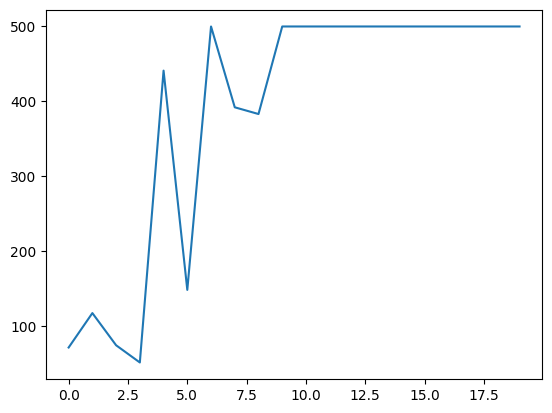

In [34]:
# To obtain the number of parameters to optimzie we can use the nparams attribute of the NHNN class
fka = NCHL([4,10,2])
number_of_parameters = fka.nparams

# optimizer initialization
opt = Optimizer(number_of_parameters)

best_sol_fitness = []

# Iterates for some generations
for i in tqdm(range(20)):
    inds = opt.ask()
    fits = [eval(ind) for ind in inds]
    opt.tell(fits)
    best_sol_fitness.append(-np.min(fits))

plt.plot(best_sol_fitness)